In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

# Моделирование
Теперь попробуем построить несколько моделей. Для этого:
- разделим данные на тестовую и обучающую выборки.
- в обучающей выборке выделим выборку для валидации. На ней будем тестировать модели и смотреть метрики
- после выбора лучшей модели проверим качество на тестовой выборке

## Import Libraries

In [22]:
import numpy as np

from src.data.dataset import load_dataset, save_dataset
from src.models.model import fit_model

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
pylab.rcParams['figure.figsize'] = 8, 6

In [3]:
%load_ext autoreload
%autoreload 2

## Загрузка данных

In [5]:
df = load_dataset(dataset_name='train.csv', load_dir='intermediate')

## Разделение данных

In [7]:
X = df.drop('quality', axis=1)
y = df.quality

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. LinearRegression

In [13]:
fit_model(X_train, y_train, model=linear_model.LinearRegression())

TRAIN SET
Error RMSE: 0.7457341387236642
Score: 0.2811521598664931

VALIDATION SET
Error RMSE: 0.7360045458866121
Score: 0.30313623597570816


Это отправная точка. Ошибка на обучении и на валидации почти одинаковая, можно предположить, что при использовании этой модели не будет проблем с переобучением 

### 2. RandomForestRegressor

Для этой модели нужно подобрать подходящие гиперпараметры. Для этого переберём несколько основных параметров, измерим RMSE и построим график её изменения.

Будем перебирать:

- n_estimators - от 5 до 100
- max_depth - от 1 до 20

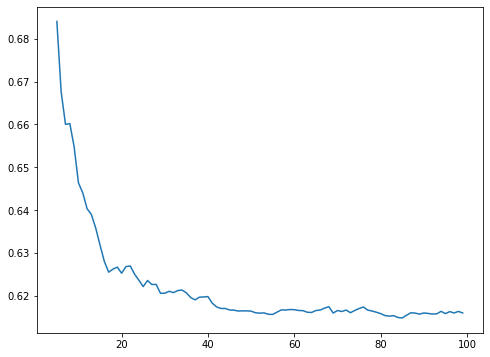

In [14]:
n_estimators = []

for i in range(5, 100):
    error = fit_model(X_train, y_train, model=ensemble.RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=i), prin=False)
    n_estimators.append(error)    
    
plt.plot(range(5, 100), n_estimators)

По графику видно, что после n_estimators = 25, ошибка убывает медленно. Остановимся на значении 55

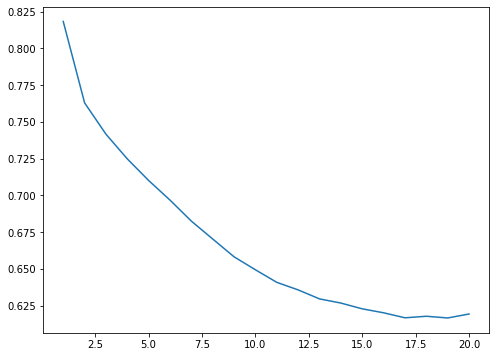

In [15]:
# max_depth
max_depth = []

for i in range(1, 21):
    error = fit_model(X_train, y_train, model=ensemble.RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=55, max_depth=i), prin=False)
    max_depth.append(error)    
    
plt.plot(range(1, 21), max_depth)

По графику видно, что после max_depth = 15, ошибка меняется незначительно. Остановимся на значении 15

На основе графиков оставляем следующие гиперпараметры:

    - n_estimators - 55
    - max_depth - 15

In [17]:
fit_model(X_train, y_train, model=ensemble.RandomForestRegressor(random_state=42, n_jobs=-1, 
                                                                 n_estimators=55, min_samples_leaf=20, max_depth=15, 
                                                                 criterion='mse'))

TRAIN SET
Error RMSE: 0.616602992195879
Score: 0.5085490509925749

VALIDATION SET
Error RMSE: 0.6812777345930382
Score: 0.40291621093985497


### 3. GradientBoostingRegressor

Будем перебирать:

- n_estimators - от 5 до 100
- max_depth - от 1 до 20
- learning_rate - от 0 до 1 с шагом 0.1  

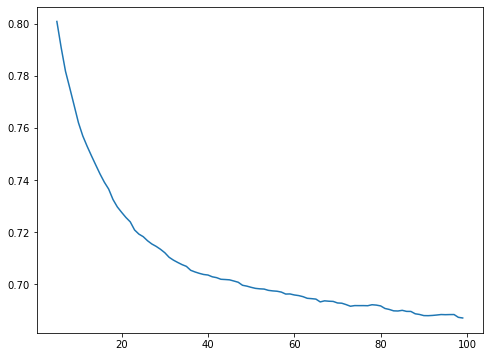

In [19]:
n_estimators = []

for i in range(5, 100):
    error = fit_model(X_train, y_train, model=ensemble.GradientBoostingRegressor(random_state=42, n_estimators=i), prin=False)
    n_estimators.append(error)    
    
plt.plot(range(5, 100), n_estimators)

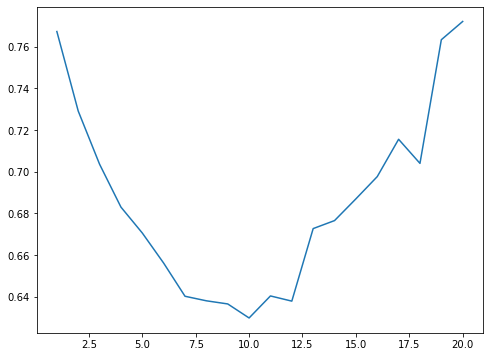

In [20]:
# max_depth
max_depth = []

for i in range(1, 21):
    error = fit_model(X_train, y_train, model=ensemble.GradientBoostingRegressor(random_state=42, n_estimators=40, max_depth=i), prin=False)
    max_depth.append(error)    
    
plt.plot(range(1, 21), max_depth)

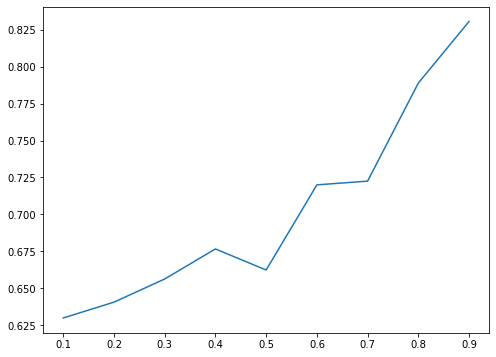

In [23]:
# learning_rate
learning_rate = []

for i in np.arange(0.1, 1., 0.1):
    error = fit_model(X_train, y_train, model=ensemble.GradientBoostingRegressor(random_state=42, n_estimators=40, max_depth=10, learning_rate=i), prin=False)
    learning_rate.append(error)    
    
plt.plot(np.arange(0.1, 1., 0.1), learning_rate)

На основе графиков оставляем следующие гиперпараметры:

    - n_estimators - 40
    - max_depth - 10
    - learning_rate - 0.2

In [24]:
fit_model(X_train, y_train, model=ensemble.GradientBoostingRegressor(random_state=42, n_estimators=40, min_samples_leaf=100, max_depth=10, loss='huber', learning_rate=0.2))

TRAIN SET
Error RMSE: 0.5759942802883611
Score: 0.5711501486203594

VALIDATION SET
Error RMSE: 0.6696587423892646
Score: 0.4231087195872206


### 4. StackingRegressor

In [28]:
boosting_params = {'n_estimators': 40,
                  'max_depth': 10,
                  'min_samples_leaf': 100,
                   'loss': 'huber',
                  'random_state': 42}    

forest_params = {'n_estimators': 50,
                  'max_depth': 13,
                  'min_samples_leaf': 20,
                  'n_jobs': -1,
                  'random_state': 42}

In [29]:
model=ensemble.StackingRegressor([('gb', ensemble.GradientBoostingRegressor(**boosting_params)),('rf', ensemble.RandomForestRegressor(**forest_params))], 
                         linear_model.LinearRegression())

In [30]:
fit_model(X_train, y_train, model=model)

TRAIN SET
Error RMSE: 0.6152440136566277
Score: 0.5107129565035876

VALIDATION SET
Error RMSE: 0.6743905913096796
Score: 0.41492721894654805


## Оценка

Мы получили следующие результаты:

- Обычная линейная регрессия показывает худший результат из представленных моделей (RMSE: 0.73), но не имеет проблем с переобучением    
- Случайный лес, градиентный бустинг и стекинг показывают практически одинаковые результаты (RMSE: 0.66-0.68), но есть переобучение
- Случайный лес работает чуть лучше, чем остальные модели и имеет меньшее переобучение.
    
Ранее мы выделили тестовую выборку, которую ещё не использовали. Протестируем на этой выборке полученную модель случайного леса.

In [31]:
fit_model(X_train, y_train, model=ensemble.RandomForestRegressor(**forest_params), show_results=True, X_test=X_test, y_test=y_test)

TEST SET
Error RMSE: 0.6343878768299165
Score: 0.43697774004192014


Результат получился даже лучше, чем на валидационной выборке.